<a href="https://colab.research.google.com/github/deeshlby/instructional_resources/blob/main/Final_Project_Bert_Uncased_Oct_19_SQuAD_AAI_520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers huggingface_hub
!pip install transformers==4.12.3
!pip install langchain
!pip install langchain sentence_transformers
!pip install chromadb
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 24.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements

In [2]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
import numpy as np
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW, BertConfig,PreTrainedModel
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import numpy as pd

# Import Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [20]:
MODEL_PATH = "bert-base-uncased"

## Load Dataset

In [3]:
#get SQuAD v2
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-10-20 03:10:54--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  77.9MB/s    in 0.5s    

2023-10-20 03:10:55 (77.9 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-10-20 03:10:55--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

In [4]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [5]:
#Squad2 dataset have questions with impossible or no answers.
# The code below will only return questions wich have answers (i.e. not the ones flagged as imposible to answer)
def get_data(path):
    #read each file and retrieve the titles, contexts, qustions and answers.
    #Find the impossible questions, and change to lower case.
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  titles = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    titles.append(group['title'])
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, titles, contexts, questions, answers

In [6]:
# read the training dataset and apply the function get_data.
num_q, num_pos, num_imp, train_titles, train_contexts, train_questions, train_answers = get_data('train-v2.0.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp


In [7]:
# First 15 topics in data set
train_titles[0:15]

['Beyoncé',
 'Frédéric_Chopin',
 'Sino-Tibetan_relations_during_the_Ming_dynasty',
 'IPod',
 'The_Legend_of_Zelda:_Twilight_Princess',
 'Spectre_(2015_film)',
 '2008_Sichuan_earthquake',
 'New_York_City',
 'To_Kill_a_Mockingbird',
 'Solar_energy',
 'Kanye_West',
 'Buddhism',
 'American_Idol',
 'Dog',
 '2008_Summer_Olympics_torch_relay']

In [8]:
# Create new conversational entries in format of SQuAD to train model to be conversational -> Append to training data
# Context paragraph for conversation
cc = """Hello nice to meet you!
My name is Wiki-bot and I am here to help.
No problem! Always happy to help!
Bye! Have a nice day!
I am doing well, thanks for asking!
Good morning! How can I help you?
Good afternoon! How can I help you?
Good evening! How can I help you?
I can help by answering questions about a variety of topics! Ask me what topics I know about.
Examples of topics I know about are: (Beyoncé, New York City, Frédéric Chopin, Solar Energy)
"""
# str(train_titles)
# {'text': [str(train_titles[0:15])], 'answer_start':[0]},

dialouge = { 'question': ['Hello','Who are you?','Thanks for the help',
                          'Goodbye','How are you doing?','Good morning','Good afternoon','Good evening',
                          'How can you help?','What topics do you know about?'],
             'context':[cc,cc,cc,cc,cc,cc,cc,cc,cc,cc],
             'answer':[{'text':'Hello nice to meet you!','answer_start':0},
              {'text':'My name is Wiki-bot and I am here to help.','answer_start':25},
                        {'text':'No problem! Always happy to help!','answer_start':69},
                       {'text': 'Bye! Have a nice day!','answer_start':104},
                       {'text': 'I am doing well, thanks for asking!','answer_start':127},
                       {'text': 'Good morning! How can I help you?','answer_start':163},
                       {'text': 'Good afternoon! How can I help you?','answer_start':197},
                       {'text': 'Good evening! How can I help you?','answer_start':233},
                       {'text':'I can help by answering questions about a variety of topics! Ask me what topics I know about.',
                        'answer_start':267},
                       {'text': 'Examples of topics I know about are: (Beyoncé, New York City, Frédéric Chopin, Solar Energy)',
                        'answer_start':361}]
}

In [ ]:
# Answers
dialouge['answer']

[{'text': 'Hello nice to meet you!', 'answer_start': 0},
 {'text': 'My name is Wiki-bot and I am here to help.', 'answer_start': 25},
 {'text': 'No problem! Always happy to help!', 'answer_start': 69},
 {'text': 'Bye! Have a nice day!', 'answer_start': 104},
 {'text': 'I am doing well, thanks for asking!', 'answer_start': 127},
 {'text': 'Good morning! How can I help you?', 'answer_start': 163},
 {'text': 'Good afternoon! How can I help you?', 'answer_start': 197},
 {'text': 'Good evening! How can I help you?', 'answer_start': 233},
 {'text': 'I can help by answering questions about a variety of topics! Ask me what topics I know about.',
  'answer_start': 267},
 {'text': 'Examples of topics I know about are: (Beyoncé, New York City, Frédéric Chopin, Solar Energy)',
  'answer_start': 361}]

In [9]:
# Append conversational sentences to training data
for q in dialouge['question']:
  train_questions.append(q)
for c in dialouge['context']:
  train_contexts.append(c)
for a in dialouge['answer']:
  train_answers.append(a)

In [10]:
# Print the first 10 questions and 10 answers.
print(train_questions[0:10])
print(train_answers[0:10])

['when did beyonce start becoming popular?', 'what areas did beyonce compete in when she was growing up?', "when did beyonce leave destiny's child and become a solo singer?", 'in what city and state did beyonce  grow up? ', 'in which decade did beyonce become famous?', 'in what r&b group was she the lead singer?', 'what album made her a worldwide known artist?', "who managed the destiny's child group?", 'when did beyoncé rise to fame?', "what role did beyoncé have in destiny's child?"]
[{'text': 'in the late 1990s', 'answer_start': 269}, {'text': 'singing and dancing', 'answer_start': 207}, {'text': '2003', 'answer_start': 526}, {'text': 'Houston, Texas', 'answer_start': 166}, {'text': 'late 1990s', 'answer_start': 276}, {'text': "Destiny's Child", 'answer_start': 320}, {'text': 'Dangerously in Love', 'answer_start': 505}, {'text': 'Mathew Knowles', 'answer_start': 360}, {'text': 'late 1990s', 'answer_start': 276}, {'text': 'lead singer', 'answer_start': 290}]


In [11]:
# read the dev dataset and apply the function get_data.

num_q, num_pos, num_imp, valid_titles, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 142192
Total number of Answerable questions: 92749
Total number of impossible questions: 49443


In [12]:
# print the first 10 valid questions and answers.
print(valid_questions[0:10])
print(valid_answers[0:10])

['in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'from which countries did the norse originate?', 'from which countries did the norse originate?']
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]


In [13]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [14]:
# print example number zero in train data.
print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question: when did beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [15]:
# print example number 30 in the valid dataset.
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the english name "normans" comes from the french words normans/normanz, plural of normant, modern french normand, which is itself borrowed from old low franconian nortmann "northman" or directly from old norse norðmaðr, latinized variously as nortmannus, normannus, or nordmannus (recorded in medieval latin, 9th century) to mean "norseman, viking".
Question: what is the original meaning of the word norman?
Answer: {'text': 'norseman, viking', 'answer_start': 331, 'answer_end': 347}


## Tokenize

### Find max lengths

653


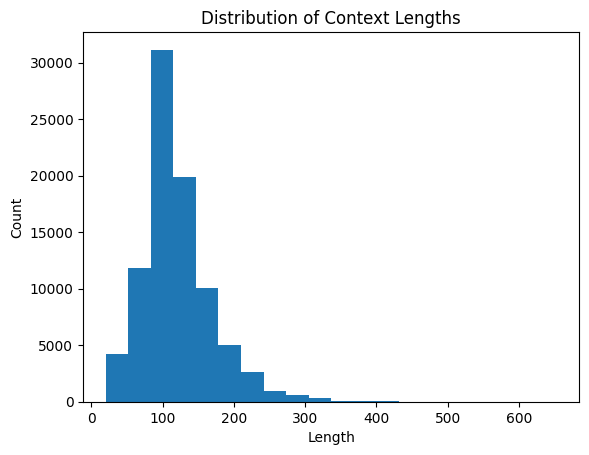

In [16]:
#Analyze the histogram of the context length
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

40
86831


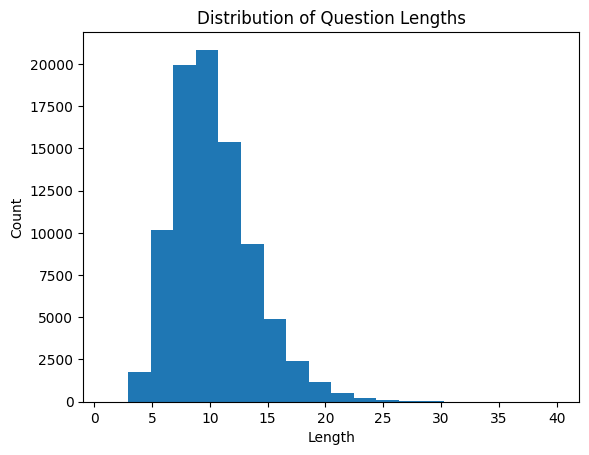

In [17]:
#Analyze the length of the answers
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [18]:
MAX_LENGTH = 250

### tokenize

In [21]:
# Load the Bert_base_uncased tokenizer. Apply this to the training data. Apply trucation for context larger than max token length, and pad the short token length so all token has same length
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)


In [22]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
# print the keys in the dictionary. Then prent the total number of training examples, and the length of the input_id (token length)
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86831
250


In [ ]:
# print the input_ids for the first example.
print(train_encodings_fast['input_ids'][0])

[101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193, 1011, 2028, 3895, 1000, 4689

In [23]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
#train_answer_encodings_fast = tokenizerFast(train_answers[0]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)


In [24]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)


In [25]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

0 0

split with luckett and rober
[CLS] what event caused beyonce's depression? [SEP] letoya luckett and roberson became unhappy with mathew's managing of the band and eventually were replaced by farrah franklin and michelle williams. beyonce experienced depression following the split with luckett and roberson after being publicly blamed by the media, critics, and blogs for its cause. her long - standing boyfriend left her at this time. the depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. beyonce stated that she struggled to speak about her depression because destiny's child had just won their first grammy award and she feared no one would take her seriously. beyonce would later speak of her mother as the person who helped her fight it. franklin was dismissed, leaving just beyonce, rowland, and williams. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86831


In [26]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

1190


In [27]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86831


In [28]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

68
71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [29]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [30]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

393


In [31]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

france
france
[CLS] in what country is normandy located? [SEP] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
86831
86831
86831
20302
20302
20302


In [ ]:
#tokenizerFast.decode(train_encodings_fast['input_ids'][0])

In [32]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny\'s child. managed by her father, mathew knowles, the group became one of the world\'s best - selling girl groups of all time. their hiatus saw the release of beyonce\'s debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [33]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

in the late 1990s


In [34]:

answer_start_index = 75
answer_end_index = 79

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'in the late 1990s'

In [35]:
# remove stop words for language variations

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
text = 'This is a sample text with stop words'
words = text.split()
filtered_words = [word for word in words if word not in stop]
filtered_text = ' '.join(filtered_words)
print(filtered_text)


This sample text stop words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [36]:
# N-grams for context management

from nltk.util import ngrams
text = 'This is a sample text'
ngram_list = ngrams(text.split(), 2)
print(list(ngram_list))


[('This', 'is'), ('is', 'a'), ('a', 'sample'), ('sample', 'text')]


## Create Dataset and Dataloaders

In [ ]:
# code to create a dataset in the format expected by the model. With following keys: input_ids, token_type_ids, attention_mask, start_position, end_position
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
# Use InputDataset function to transform the train and valid dataset.
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

86831
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
# Load the data with required batch size for training and evaluation
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:

#print(data['targets'].shape)

## Create Model

In [ ]:
#model = BertForQuestionAnswering.from_pretrained(MODEL_PATH)

In [ ]:
# Load the Bert model. Then create class QAModel that has Bertm dropout layer and two linear layers followed by relu nonlineratiy
bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"
class MyConfig(BertConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

#nn.Module
class QAModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self,config):
        #super(QAModel, self,config).__init__()
        super().__init__(config)
        self.config = config
        self.encoder = None
        self.decoder = None

        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def to_dict(self):
        return {

              "config": self.config
            #"encoder": self.encoder.to_dict(),
            #"decoder": self.decoder.to_dict(),
        }

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [ ]:
config = MyConfig()
model = QAModel(config)

In [37]:
# Initalize the device used for training and evaluation. Use GPU/CUDA if available otherwise use CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Create Loss Functions

In [ ]:
# my function to manually calculate Cross Entropy Loss
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
# my focal loss function. Focal loss is a loss function that better handles data imbalance.
# Focal Loss = (True Vector)*((1 - probs)^Gamma)*log(probs)
# where Gamma is a factor we use. setting Gamma = 0 makes this a Cross Entropy Loss function
#

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

### OPTIONAL: Uncomment this code if you want to test on one input .....

In [ ]:
#data = next(iter(train_data_loader))
#data.keys()

In [ ]:
#print(data['input_ids'].shape)
#print(data['attention_mask'].shape)

In [ ]:
#run one row
#model.to(device)
#model.train()
#input_ids = data['input_ids'][0].unsqueeze(0).to(device)
#attention_mask = data['attention_mask'][0].unsqueeze(0).to(device)
#start_positions = data['start_positions'][0].unsqueeze(0).to(device)
#end_positions = data['end_positions'][0].unsqueeze(0).to(device)

In [ ]:
#out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

In [ ]:
#print(f"start logits shape: {out_start.shape}")
#print(f"end logits shape: {out_end.shape}")

In [ ]:
#answer_start_index = out_start.argmax()
#answer_end_index = out_end.argmax()
#print(answer_start_index)
#print(answer_end_index)

## Train Loop

In [ ]:
# Define training parameters. Use Adam for backprop optimization.
# Use an exponential learning rate with initial learning rate of 2e-5. use weight_decay of 2e-2 which is used for regularization.
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Start the training. Define the training epoch function.
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()

        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
# start the evalulation model. Define the evaluation model.
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [ ]:
# start the training, and for each epoch use the training epoch model
EPOCHS = 2

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

#val_acc, val_loss = eval_model(model, valid_data_loader)
#print(f"Validation Accuracy: {val_acc}   Validation Loss: {val_loss}")


Running Epoch : 100%|██████████| 5427/5427 [20:30<00:00,  4.41it/s]


Train Accuracy: 0.6096561943406181      Train Loss: 1.194892874865851


Running Evaluation: 100%|██████████| 635/635 [01:30<00:00,  7.05it/s]


Validation Accuracy: 0.6581060180103215


Running Epoch : 100%|██████████| 5427/5427 [20:26<00:00,  4.43it/s]


Train Accuracy: 0.7325137430173555      Train Loss: 0.6700134793791034


Running Evaluation: 100%|██████████| 635/635 [01:30<00:00,  7.06it/s]

Validation Accuracy: 0.6734849550181956


In [ ]:
# print the last learning rate.
scheduler.get_last_lr()

[1.62e-05]

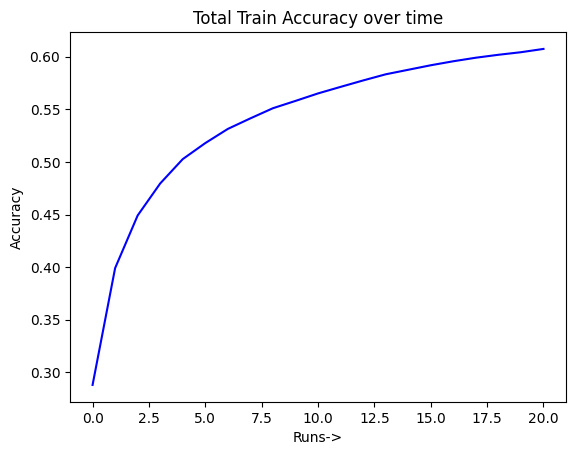

In [ ]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

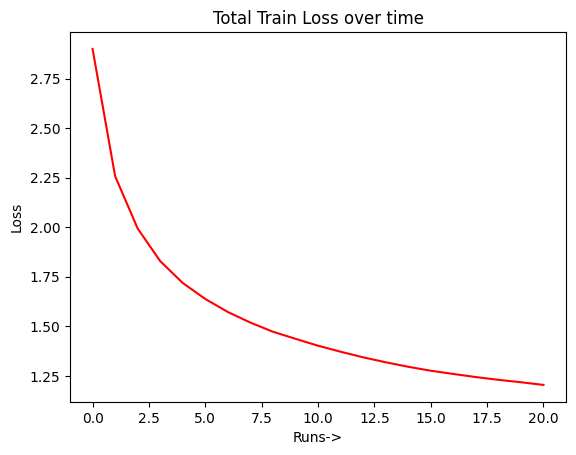

In [ ]:
# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
# Save the training model
#torch.save(model.state_dict(),'/content/drive/MyDrive/Model_Conversational.pt')

In [ ]:
# Code to load the trained model
#import torch

# Load state dict from a file
#state_dict = torch.load('/content/drive/modelOct7.pth')

# Load the state dict into the model
#model.load_state_dict(state_dict)

## Test

In [38]:
# define a function to get the answer based on question and context and transform the answer from tokens to text.
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [39]:
# compare golden answer and predicted answer for the first test record.
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: in what country is normandy located?
Expected Answer: {'text': 'france', 'answer_start': 159, 'answer_end': 165}


NameError: ignored

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: who was the norse leader?
Expected Answer: {'text': 'rollo', 'answer_start': 308, 'answer_end': 313}
Predicted Answer: rollo


In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the norman dynasty had a major political, cultural and military impact on medieval europe and even the near east. the normans were famed for their martial spirit and eventually for their christian piety, becoming exponents of the catholic orthodoxy into which they assimilated. they adopted the gallo-romance language of the frankish land they settled, their dialect becoming known as norman, normaund or norman french, an important literary language. the duchy of normandy, which they formed by treaty with the french crown, was a great fief of medieval france, and under richard i of normandy was forged into a cohesive and formidable principality in feudal tenure. the normans are noted both for their culture, such as their unique romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. norman adventurers founded the kingdom of sicily under roger ii after conquering southern italy on the saracens and byzantines, and an exped

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: as of august 2010, victoria had 1,548 public schools, 489 catholic schools and 214 independent schools. just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. over 61 per cent of private students attend catholic schools. more than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. victoria has about 63,519 full-time teachers.
Question: how many full time teachers does victoria have?
Expected Answer: {'text': '63,519', 'answer_start': 541, 'answer_end': 547}
Predicted Answer: 63, 519


In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: oxygen is more soluble in water than nitrogen is. water in equilibrium with air contains approximately 1 molecule of dissolved o
2 for every 2 molecules of n
2, compared to an atmospheric ratio of approximately 1:4. the solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·l−1) dissolves at 0 °c than at 20 °c (7.6 mg·l−1). at 25 °c and 1 standard atmosphere (101.3 kpa) of air, freshwater contains about 6.04 milliliters (ml) of oxygen per liter, whereas seawater contains about 4.95 ml per liter. at 5 °c the solubility increases to 9.0 ml (50% more than at 25 °c) per liter for water and 7.2 ml (45% more) per liter for sea water.
Question: how much oxygen is found is a liter of fresh water under normal conditions?
Expected Answer: {'text': '6.04 milliliters', 'answer_start': 441, 'answer_end': 457}
Predicted Answer: 14. 6 mg · l−1 ) dissolves at 0 °c than at 20 °c ( 7. 6 mg · l−1 ). at 25 °c and 1 standard atmosphere ( 101. 3 kpa ) of air, fresh

In [ ]:
# In order to calculate metrics such as Exact match and F1 score, we need to normalize the golden and predicted answers to a format that can be understood by the evaluation code,
# In particular, two answers that only differ by an extra white space, or a comma, or a stop word are supposed to be an exact match. But in order to guarantee this
# The following function is desgined to perform this text normalization.

# Then we write a code to compute the exact match and F1 score.
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    import re
    import string

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove spaces around hyphens
        text = re.sub(r'\s?-\s?', '-', text)
        text=re.sub(r'\s?\.\s?', '.', text)
        text=re.sub(r'\s?\,\s?', ',', text)

        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return remove_articles(remove_punc(lower(white_space_fix(s))))

def compute_exact(a_gold, a_pred):
    """Computes the Exact Match metric between a ground truth and a prediction."""
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    """Computes the F1 score between a ground truth and a prediction."""

    gold_toks = normalize_answer(a_gold).split()
    pred_toks = normalize_answer(a_pred).split()
    common = set(gold_toks) & set(pred_toks)
    num_same = len(common)

    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either the true answer or predicted answer is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1

# Example usage of the answer normalization and apply exact match and F1 score
gold_answer = "king charless iii of france"
predicted_answer = "king charless iii"

print(f"Gold Answer: {gold_answer}")
print(f"Predicted Answer: {predicted_answer}")
print(normalize_answer(gold_answer).split())
print(normalize_answer(predicted_answer).split())
print(f"Exact Match: {compute_exact(gold_answer, predicted_answer)}")
print(f"Exact Match: {compute_exact(gold_answer, predicted_answer)}")
print(f"F1 Score: {compute_f1(gold_answer, predicted_answer):.2f}")


Gold Answer: king charless iii of france
Predicted Answer: king charless iii
['king', 'charless', 'iii', 'of', 'france']
['king', 'charless', 'iii']
Exact Match: 0
Exact Match: 0
F1 Score: 0.75


In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: as of august 2010, victoria had 1,548 public schools, 489 catholic schools and 214 independent schools. just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. over 61 per cent of private students attend catholic schools. more than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. victoria has about 63,519 full-time teachers.
Question: how many full time teachers does victoria have?
Expected Answer: {'text': '63,519', 'answer_start': 541, 'answer_end': 547}
Predicted Answer: 63, 519


In [ ]:
temp1=valid_answers[test_rec]['text']
temp2=get_answer(question, context)
print(compute_exact(temp1, temp2))

print(normalize_answer(temp1))
print(normalize_answer(temp2))
print(temp2.split())
print(temp1.split())
print(len(valid_contexts))



1
63519
63519
['63,', '519']
['63,519']
20302


In [ ]:
# write a code to calculate the exact match and F1 score. We selected 1000 test example to calculate the statistics since it takes time.
EM=0
F1score=0
for i in range(1000,2000):
    temp1=valid_answers[i]['text']
    temp2=get_answer(valid_questions[i], valid_contexts[i])
    #if compute_f1(temp1, temp2)==0:
    #   print(temp1)
    #   print(temp2)
    #   input('Press any key to continue')
    EM=EM+compute_exact(temp1, temp2)
    F1score=F1score+compute_f1(temp1, temp2)
print('Exact Match = ', EM/1000)
print('F1 Score = ', F1score/1000)




Exact Match =  0.563
F1 Score =  0.7728600120971927


Bert based uncased pretrained model was imported from GitHub : https://gist.github.com/vvr-rao/bdd3a17d8d21974159348438427ca907

## Chatbot UI

In [40]:
# Add all data for chatbot
all_contexts = train_contexts + valid_contexts
all_questions = train_questions + valid_questions
all_answers = train_answers + valid_answers
all_titles = train_titles + valid_titles

In [ ]:
# Use Langchain to add context awareness to chat bot
# Use code from this article as a template:
# https://archive.ph/20230914024930/https://towardsdatascience.com/4-ways-of-question-answering-in-langchain-188c6707cc5a
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import SpacyEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import Chroma

# Get all uniques contexts
docs = np.unique(all_contexts)
texts = [str(i) for i in docs]

# Use SpaCy embeddings
em = SpacyEmbeddings()
embeddings = em.embed_documents(texts)


In [ ]:
# Vectorstore
db = Chroma.from_texts(texts,em)
ret = db.as_retriever(search_type = 'similarity')

In [ ]:
# Convert model to dictionary, create conversational chain
dict_ = model.to_dict()
bert_qa = ConversationalRetrievalChain.from_llm(llm = dict_,retriever = ret)

ValidationError: ignored

In [46]:
from transformers import BertTokenizer, BertForQuestionAnswering

tokenizer = BertTokenizer.from_pretrained("deeshlby/Chat-Bot-AAI-520")
model = BertForQuestionAnswering.from_pretrained("deeshlby/Chat-Bot-AAI-520")

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at deeshlby/Chat-Bot-AAI-520 and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Initalize the device used for training and evaluation. Use GPU/CUDA if available otherwise use CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [54]:
def get_answerv2(question, context):
    # Tokenization and input preparation
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Model inference
    outputs = model(**inputs)
    output_start = outputs.start_logits
    output_end = outputs.end_logits

    # Extracting the predicted answer tokens' positions
    answer_start = torch.argmax(output_start)
    answer_end = torch.argmax(output_end)

    # Convert tokens to string
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end+1])
    answer = tokenizer.convert_tokens_to_string(tokens)

    return answer

In [55]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    import re
    import string

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove spaces around hyphens
        text = re.sub(r'\s?-\s?', '-', text)
        text=re.sub(r'\s?\.\s?', '.', text)
        text=re.sub(r'\s?\,\s?', ',', text)

        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return remove_articles(remove_punc(lower(white_space_fix(s))))

In [56]:
def compute_f1(a_gold, a_pred):
    """Computes the F1 score between a ground truth and a prediction."""

    gold_toks = normalize_answer(a_gold).split()
    pred_toks = normalize_answer(a_pred).split()
    common = set(gold_toks) & set(pred_toks)
    num_same = len(common)

    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either the true answer or predicted answer is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1

In [61]:
def wiki_botv2():
  # Chat history
  chat_history = []
  # Welcome message
  print('Hello my name is Wiki-bot! How can I help you?')
  while True:
    question = input("\nPlease enter your question, if you want to stop please enter stop: \n")
    temp_F1Score=0
    for q,i in zip(all_questions,range(0,len(all_questions)-1)):
      # Search for best match that has highest F1 score
      if compute_f1(question,q) > temp_F1Score:
        temp_F1Score = compute_f1(question,q)
        best_match = i
        best_question=q
    answer=get_answerv2(best_question, all_contexts[best_match])
    print('Answer: ', answer)

    if question == 'stop':
      print('Thank you for using Wiki-bot!')
      break

In [62]:
wiki_botv2()


Hello my name is Wiki-bot! How can I help you?

Please enter your question, if you want to stop please enter stop: 
who was the norse leader?
Answer:  normans emerged initially in the first half of the 10th century , and it continued to evolve over the succeeding centuries . [SEP]

Please enter your question, if you want to stop please enter stop: 
how much oxygen is found is a liter of fresh water under normal conditions?
Answer:  freshwater contains about 6 . 04 milliliters ( ml ) of oxygen per liter , whereas seawater contains about 4 . 95 ml per liter . at 5 °c the solubility increases to 9 . 0 ml ( 50 % more than at 25 °c ) per liter for water and 7 . 2 ml ( 45 % more ) per liter for sea water . [SEP]

Please enter your question, if you want to stop please enter stop: 
how much oxygen is found is a liter of salt water under normal conditions?
Answer:  freshwater contains about 6 . 04 milliliters ( ml ) of oxygen per liter , whereas seawater contains about 4 . 95 ml per liter . at 

In [63]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5579 sha256=fde01fa45ac5e7306d5d2aeab0cca84d6a3f7f1817509bfb4709b7886403e647
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [64]:
import tensorflow as tf
import transformers
from transformers import pipeline

from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import gradio as gr

model2 = TFAutoModelForQuestionAnswering.from_pretrained("deeshlby/Chat-Bot-AAI-520",return_dict=False, from_pt=True)
tokenizer2 = AutoTokenizer.from_pretrained("deeshlby/Chat-Bot-AAI-520", from_pt=True)
nlp = pipeline("question-answering", model=model2, tokenizer=tokenizer2)


# creating the function
def func(context, question):
  result = nlp(question = question, context=context)
  return result['answer']


# creating the interface
app = gr.Interface(fn=func, inputs = ['textbox', 'text'], outputs = 'textbox', title = 'Question Answering ChatBot', theme = 'dark-grass', description = 'Input context and question, then get answers!')

# launching the app
app.launch(inline=False, share=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['linear_relu_stack.1.weight', 'linear_relu_stack.3.bias', 'l2.weight', 'linear_relu_stack.1.bias', 'l2.bias', 'l1.bias', 'l1.weight', 'linear_relu_stack.3.weight']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be 

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0e52e067f668031911.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


We deploy the model UI on huggingface.co/spaces  https://huggingface.co/spaces/deeshlby/QA_Chatbot_AAI_520